In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os

import matplotlib.pyplot as plt

In /home/ubuntu/anaconda3/envs/tf2_pcse/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/anaconda3/envs/tf2_pcse/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ubuntu/anaconda3/envs/tf2_pcse/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ubuntu/anaconda3/envs/tf2_pcse/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
from pcse.models import Wofost71_PP

from pcse.fileinput import CABOFileReader, ExcelWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider

from pcse.base import ParameterProvider, VariableKiosk
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLAgroManagementReader

In [3]:
from pcse.fileinput import YAMLCropDataProvider
from pcse.agromanager import AgroManager

In [4]:
data_dir = './custom_examples/'
crop_id = ('wheat', 'Winter_wheat_107')

### Crop parameter

In [5]:
cropdata = YAMLCropDataProvider()
cropdata.print_crops_varieties()

crop 'barley', available varieties:
 - 'Spring_barley_301'
crop 'cassava', available varieties:
 - 'Cassava_VanHeemst_1988'
crop 'chickpea', available varieties:
 - 'Chickpea_VanHeemst_1988'
crop 'cotton', available varieties:
 - 'Cotton_VanHeemst_1988'
crop 'cowpea', available varieties:
 - 'Cowpea_VanHeemst_1988'
crop 'fababean', available varieties:
 - 'Faba_bean_801'
crop 'groundnut', available varieties:
 - 'Groundnut_VanHeemst_1988'
crop 'maize', available varieties:
 - 'Maize_VanHeemst_1988'
 - 'Grain_maize_201'
 - 'Grain_maize_202'
 - 'Grain_maize_203'
 - 'Grain_maize_204'
 - 'Grain_maize_205'
crop 'millet', available varieties:
 - 'Millet_VanHeemst_1988'
crop 'mungbean', available varieties:
 - 'Mungbean_VanHeemst_1988'
crop 'pigeonpea', available varieties:
 - 'Pigeonpea_VanHeemst_1988'
crop 'potato', available varieties:
 - 'Potato_701'
 - 'Potato_702'
 - 'Potato_703'
 - 'Potato_704'
crop 'rapeseed', available varieties:
 - 'Oilseed_rape_1001'
 - 'Oilseed_rape_1002'
 - 'Oils

In [6]:
cropdata.set_active_crop(crop_id[0], crop_id[1])

## CO2 농도에 따른 차이 확인

In [7]:
CO2_variations = [_ for _ in range(350, 610, 50)]
DVSs = []
TAGPs = []
TWSOs = []
LAIs = []

In [8]:
CO2_variations

[350, 400, 450, 500, 550, 600]

In [9]:
for CO2_concentration in CO2_variations:
    _ = os.path.join(data_dir, 'ec3.soil')
    soildata = CABOFileReader(_)
    sitedata = WOFOST71SiteDataProvider(WAV=50, CO2=CO2_concentration)
    parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

    wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)

    _ = os.path.join(data_dir, 'wheat_calendar.agro')
    agromanagement = YAMLAgroManagementReader(_)
    
    wofsim = Wofost71_PP(parameters, wdp, agromanagement)
    
    wofsim.run_till_terminate()
    
    output_df = pd.DataFrame(wofsim.get_output()).set_index('day')
    output_df = output_df.drop(['SM', 'WWLOW'], axis=1).dropna(how='all')
    output_df.columns = [_ + f'_{CO2_concentration}' for _ in output_df.columns]
#     output_df.to_csv(f'./results/PCSE_wheat_out_{CO2_concentration}.csv')

    DVSs.append(output_df[f'DVS_{CO2_concentration}'])
    TAGPs.append(output_df[f'TAGP_{CO2_concentration}'])
    TWSOs.append(output_df[f'TWSO_{CO2_concentration}'])
    LAIs.append(output_df[f'LAI_{CO2_concentration}'])

In [10]:
DVSs = pd.concat(DVSs, axis=1)
TAGPs = pd.concat(TAGPs, axis=1)
TWSOs = pd.concat(TWSOs, axis=1)
LAIs = pd.concat(LAIs, axis=1)

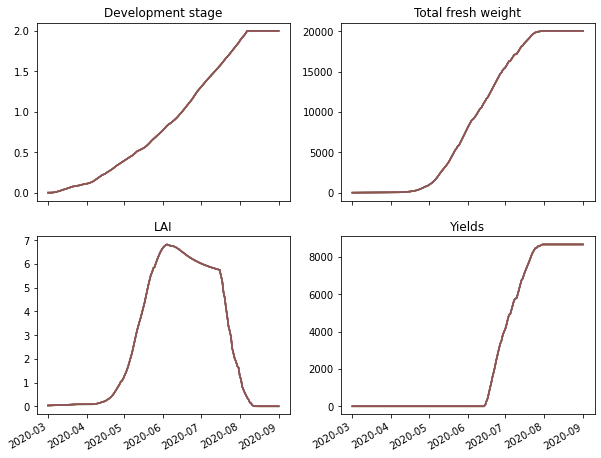

In [11]:
title_ = ["Development stage", "Total fresh weight", "LAI", "Yields"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
x_ = DVSs.index
for ax, target, title in zip(axes.flatten(), [DVSs, TAGPs, LAIs, TWSOs], title_):
    ax.plot(x_, target)
    ax.set_title(title)
fig.autofmt_xdate()

#### PCSE의 Wheat crop은 site의 CO2 농도에 둔감함.

## 온도에 따른 차이 확인

In [12]:
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
weather_df = pd.DataFrame(wdp.export())

In [13]:
DVSs = []
TAGPs = []
TWSOs = []
LAIs = []

In [14]:
for i in range(20):
    print(f'Simulation for +{i/10} °C...', end='')
    header_df = pd.read_excel('./pcse_examples/nl1.xlsx')

    temp_df = weather_df[['DAY', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN']].copy()
    temp_df.loc[:, 'SNOWDEPTH'] = -999
    temp_df.loc[:, 'IRRAD'] /= 1000 # J -> kJ
    temp_df.loc[:, 'VAP'] /= 10 # hPa -> kPa
    temp_df.loc[:, ['TMAX', 'TMIN']] += i/10 # Treatment
    temp_df.columns = header_df.columns

    new_weather_df = pd.concat([header_df.iloc[:11].copy(), temp_df], axis=0)
    new_weather_df.to_excel('./custom_examples/weather_set.xlsx', index=False)
    wdp = ExcelWeatherDataProvider('./custom_examples/weather_set.xlsx')
    
    _ = os.path.join(data_dir, 'ec3.soil')
    soildata = CABOFileReader(_)
    sitedata = WOFOST71SiteDataProvider(WAV=50, CO2=360)
    parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

    _ = os.path.join(data_dir, 'wheat_calendar.agro')
    agromanagement = YAMLAgroManagementReader(_)
    
    wofsim = Wofost71_PP(parameters, wdp, agromanagement)
    
    wofsim.run_till_terminate()
    
    output_df = pd.DataFrame(wofsim.get_output()).set_index('day')
    output_df = output_df.drop(['SM', 'WWLOW'], axis=1).dropna(how='all')
    output_df.columns = [_ + f'_{i/10}' for _ in output_df.columns]

    DVSs.append(output_df[f'DVS_{i/10}'])
    TAGPs.append(output_df[f'TAGP_{i/10}'])
    TWSOs.append(output_df[f'TWSO_{i/10}'])
    LAIs.append(output_df[f'LAI_{i/10}'])
    
    print(' Done.')

Simulation for +0.0 °C... Done.
Simulation for +0.1 °C... Done.
Simulation for +0.2 °C... Done.
Simulation for +0.3 °C... Done.
Simulation for +0.4 °C... Done.
Simulation for +0.5 °C... Done.
Simulation for +0.6 °C... Done.
Simulation for +0.7 °C... Done.
Simulation for +0.8 °C... Done.
Simulation for +0.9 °C... Done.
Simulation for +1.0 °C... Done.
Simulation for +1.1 °C... Done.
Simulation for +1.2 °C... Done.
Simulation for +1.3 °C... Done.
Simulation for +1.4 °C... Done.
Simulation for +1.5 °C... Done.
Simulation for +1.6 °C... Done.
Simulation for +1.7 °C... Done.
Simulation for +1.8 °C... Done.
Simulation for +1.9 °C... Done.


In [15]:
DVSs = pd.concat(DVSs, axis=1)
TAGPs = pd.concat(TAGPs, axis=1)
TWSOs = pd.concat(TWSOs, axis=1)
LAIs = pd.concat(LAIs, axis=1)

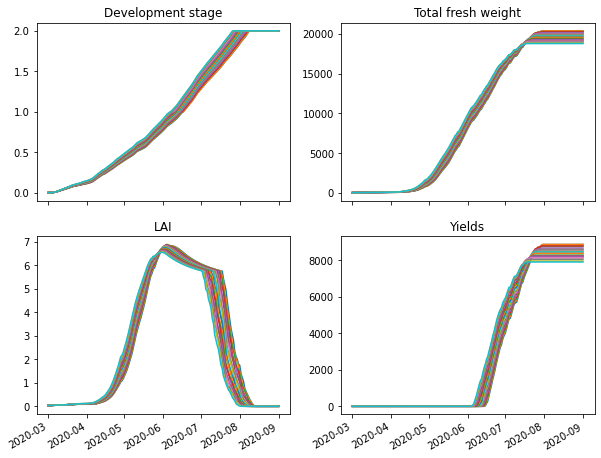

In [16]:
title_ = ["Development stage", "Total fresh weight", "LAI", "Yields"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
x_ = DVSs.index
for ax, target, title in zip(axes.flatten(), [DVSs, TAGPs, LAIs, TWSOs], title_):
    ax.plot(x_, target)
    ax.set_title(title)
fig.autofmt_xdate()